In this notebook we demonstrate how we can leverage BERT to perform NER on conll2003 dataset.<br>
This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

In [133]:
#Installing required packages
# try :
#     from google.colab import files
#     %tensorflow_version 1.x
    
# except ModuleNotFoundError :
#     Print("Not Using Colab")
    
# !pip install pytorch-pretrained-bert==0.4.0
# !pip install seqeval==0.0.12

#importing packages for string processing,dataframe handling, array manipulations, etc
import string
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

#importing all the pytorch packages
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

#importing additonal packages to aid preprocessing of data
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score, recall_score, precision_score



In [134]:
# #uploading data into google colab
# #upload the test.txt and train.txt files respectively
# try :
#     from google.colab import files
#     uploaded = files.upload()

# except ModuleNotFoundError :
#     print("Not using Colab")

In [135]:
"""
Load the training/testing data. 
input: conll format data, but with only 2 tab separated colums - words and NEtags.
output: A list where each item is 2 lists.  sentence as a list of tokens, NER tags as a list for each token.
"""
#functions for preparing the data in the *.txt files
def load__data_conll(file_path):
    myoutput,words,tags = [],[],[]
    fh = open(file_path)
    for line in fh:
        line = line.strip()
        if "\t" not in line:
            #Sentence ended.
            myoutput.append([words,tags])
            words,tags = [],[]
        else:
            word, tag = line.split("\t")
            words.append(word)
            tags.append(tag)
    fh.close()
    return myoutput

"""
Get features for all words in the sentence
Features:
- word context: a window of 2 words on either side of the current word, and current word.
- POS context: a window of 2 POS tags on either side of the current word, and current tag. 
input: sentence as a list of tokens.
output: list of dictionaries. each dict represents features for that word.
"""
def sent2feats(sentence):
    feats = []
    sen_tags = pos_tag(sentence) #This format is specific to this POS tagger!
    for i in range(0,len(sentence)):
        word = sentence[i]
        wordfeats = {}
       #word features: word, prev 2 words, next 2 words in the sentence.
        wordfeats['word'] = word
        if i == 0:
            wordfeats["prevWord"] = wordfeats["prevSecondWord"] = "<S>"
        elif i==1:
            wordfeats["prevWord"] = sentence[0]
            wordfeats["prevSecondWord"] = "</S>"
        else:
            wordfeats["prevWord"] = sentence[i-1]
            wordfeats["prevSecondWord"] = sentence[i-2]
        #next two words as features
        if i == len(sentence)-2:
            wordfeats["nextWord"] = sentence[i+1]
            wordfeats["nextNextWord"] = "</S>"
        elif i==len(sentence)-1:
            wordfeats["nextWord"] = "</S>"
            wordfeats["nextNextWord"] = "</S>"
        else:
            wordfeats["nextWord"] = sentence[i+1]
            wordfeats["nextNextWord"] = sentence[i+2]
        
        #POS tag features: current tag, previous and next 2 tags.
        wordfeats['tag'] = sen_tags[i][1]
        if i == 0:
            wordfeats["prevTag"] = wordfeats["prevSecondTag"] = "<S>"
        elif i == 1:
            wordfeats["prevTag"] = sen_tags[0][1]
            wordfeats["prevSecondTag"] = "</S>"
        else:
            wordfeats["prevTag"] = sen_tags[i - 1][1]

            wordfeats["prevSecondTag"] = sen_tags[i - 2][1]
            # next two words as features
        if i == len(sentence) - 2:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = "</S>"
        elif i == len(sentence) - 1:
            wordfeats["nextTag"] = "</S>"
            wordfeats["nextNextTag"] = "</S>"
        else:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = sen_tags[i + 2][1]
        #That is it! You can add whatever you want!
        feats.append(wordfeats)
    return feats


In [136]:
#preprocess the data by calling the functions
# try :
#     from google.colab import files
#     train_path = 'train.txt'
#     test_path = 'test.txt' 

# except ModuleNotFoundError :
#     train_path = 'Data/conlldata/train.txt'
#     test_path = 'Data/conlldata/test.txt'
train_path = 'Data/conlldata/train.txt'
test_path = 'Data/conlldata/test3.txt'
    
conll_train = load__data_conll(train_path)
conll_test = load__data_conll(test_path)    

In [137]:
#BERT needs us to pre-process the data in a particular way.
#Lets take the raw data from the txt files
df_train = pd.read_csv(train_path, engine="python",delimiter="\t",header=None,encoding='utf-8', on_bad_lines ="skip")
df_test = pd.read_csv(test_path, engine="python",delimiter="\t",encoding='utf-8',header=None, on_bad_lines ="skip")

In [138]:
#merge 
df = pd.merge(df_train,df_test)
label = list(df[1].values)#we will be using this to make a set of all unique labels

In [139]:
# print(conll_train)
len(conll_train) #calculating the length
np.array(conll_train, dtype=object).shape

(14041, 2)

In [140]:
np.array(conll_test, dtype=object).shape#calculating the size

(3453, 2)

We need to join all the tokens into a single sentence. We will use the untokenize function in token_utils from [this](https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py) github repo.


In [141]:
import re
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()


Lets start with pre-processing the data for BERT

In [142]:
#lets convert them to dataframs for easier handling
df_train = pd.DataFrame(conll_train,columns=["sentence","labels"])
df_test = pd.DataFrame(conll_test,columns=["sentence","labels"])

In [143]:
#getting all the sentences and labels present in both test and train
sentences = list(df_train['sentence'])+list(df_test['sentence'])
print("No of sentences:",len(sentences))
labels = list(df_train['labels'])+list(df_test['labels']) 
print("No of labels:",len(labels))

sentences = sentences[:1000]
labels = labels[:1000]

No of sentences: 17494
No of labels: 17494


In [144]:
sentences = [untokenize(sent) for sent in sentences]
sentences[0]

'EU rejects German call to boycott British lamb.'

We need to now tokenize the sentences and then add the CLS and SEP tokens as BERT expects the input in such a format.

In [145]:
#setting up pytorch to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#prescribed configurations that we need to fix for BERT.
MAX_LEN = 75
bs = 32

#BERT's implementation comes with a pretained tokenizer and a defined vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizing the text 
tokenized_texts = list(map(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'] , sentences))
print(tokenized_texts[0])

['[CLS]', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', '[SEP]']


In [146]:
labels[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [147]:
#pre-processing the labels
#converting tags to indices 
tags_vals = list(set(label))  
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [148]:
#We now need to give BERT input ids,ie, a sequence of integers which uniquely identify each input token to its index number.
#cutting and padding the tokens and labels to our desired length

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [149]:
#BERT supports something called attention masks
#Tells the model which tokens should be attended to, and which should not.
#learn more about this at https://huggingface.co/transformers/glossary.html#attention-mask

attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

Now we need to split the data into train and validation. Convert it to tensors and then create an iterator for our data

In [150]:
#split the dataset to use 20% to validate the model.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2020, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.2)

In [151]:
#pytorch requires inputs to be in the form of torch tensors
#Learn more about torch tensors at https://pytorch.org/docs/stable/tensors.html
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [152]:
#Define the Data Loaders
#Shuffle the data at training time
#Pass them sequentially during test time
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)
print("Train Data Loaders Ready")
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
print("Test Data Loaders Ready")

Train Data Loaders Ready
Test Data Loaders Ready


In [153]:
# BertForTokenClassification class of pytorch-pretrained-bert package provides  for token-level predictions
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))#loading pre trained bert
print("BERT model ready to use")

BERT model ready to use


In [154]:
#Passing model parameters into GPU
if torch.cuda.is_available():    
    print("Passing Model parameters in GPU")
    print(model.cuda()) 
else: 
    print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False

Finally, we move to fine  tuning BERT

In [155]:
#Before starting fine tuing we need to add the optimizer. Generally Adam is used
#weight_decay is added as regularization to the main weight matrices
print("Fine Tuning BERT")
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

Fine Tuning BERT


In [156]:
#accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [157]:
len(train_dataloader)

25

In [158]:
#Add the epoch number. The bert paper recomends 3-4
epochs = 2
max_grad_norm = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
train_loss_set=[]
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        b_labels = b_labels.long()
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            b_labels = b_labels.long()
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    pred_tags = [pred_tags]
    valid_tags = [valid_tags]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print("Recall Score: {}".format(recall_score(pred_tags, valid_tags)))
    print("Precision Score: {}".format(precision_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.9530907678604126
Validation loss: 0.6174175824437823
Validation Accuracy: 0.9648214285714286
F1-Score: 0.0
Recall Score: 0.0


Epoch:  50%|█████     | 1/2 [08:42<08:42, 522.96s/it]

Precision Score: 0.0
Train loss: 0.5901277136802673


Epoch: 100%|██████████| 2/2 [16:19<00:00, 489.72s/it]

Validation loss: 0.51308103118624
Validation Accuracy: 0.9689880952380953
F1-Score: 0.21757322175732216
Recall Score: 0.52
Precision Score: 0.13756613756613756


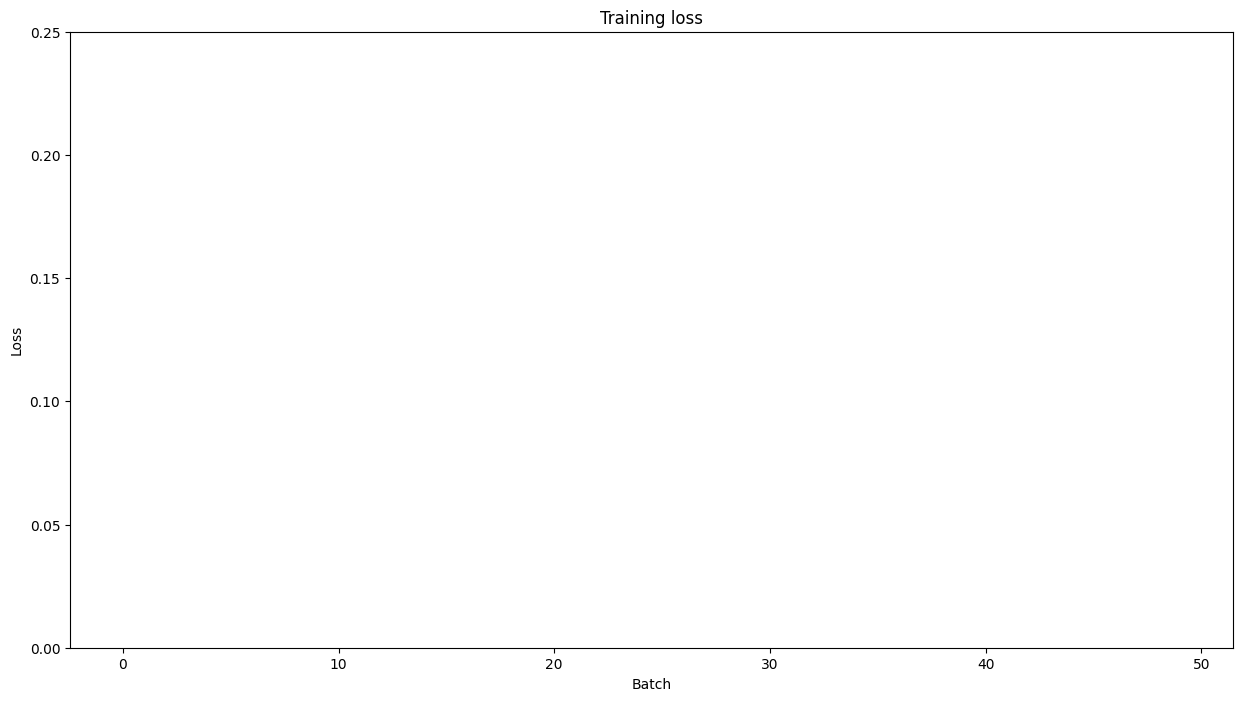

In [160]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.ylim(0,0.25)
plt.plot([loss.item() for loss in train_loss_set])
# plt.plot(train_loss_set)
plt.savefig("pngs/5_05_BERT_CONLL_NER_1.png")
plt.show()

In [162]:
#Evaluate the model
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.long()
    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Validation loss: 0.51308103118624
Validation Accuracy: 0.9689880952380953
Validation F1-Score: 0.21757322175732216
